### Google Colab Setting

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Interview/titanic/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Interview/titanic


### Modeling

In [3]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
target = train['Survived'].values
train.drop(columns=['Survived'], inplace=True)
df_all = pd.concat([train, test]).reset_index()
print('Number of records in train.csv:', len(train))
print('Number of records in test.csv:', len(test))
print('Total records:', len(df_all))

def transform_name(name):
  name_type = {'Mr.':1, 'Mrs.':2, 'Miss.':3, 'Master': 4}
  for title in name_type:
    if title in name:
      return name_type[title]
  return 0

def transform_text(text):
  if type(text) == str:
    return text.split()[0].strip('1234567890')
  else:
    return 'None'

### preprocessing
df_all['Name'] = df_all['Name'].apply(transform_name)
df_all['Name'] = df_all['Name'].astype('category')
drop_columns = ['index', 'PassengerId', 'Ticket']
df_all.drop(columns=drop_columns, inplace=True)
# mean_age = df_all['Age'].mean()
# df_all['Age'] = df_all['Age'].fillna(mean_age)
df_all['Age'] = df_all.groupby(['Sex', 'Name'])['Age'].apply(lambda x: x.fillna(x.median()))
df_all['Fare'] = df_all['Fare'].fillna(df_all['Fare'].mean())
# df_all['Fare'] = pd.qcut(df_all['Fare'], 5)
# df_all['Age'] = pd.qcut(df_all['Age'], 5)
df_all['Cabin'] = df_all['Cabin'].apply(transform_text)
df_all['Pclass'] = df_all['Pclass'].astype('category')
df_all['Embarked'] = df_all['Embarked'].fillna('S')

Number of records in train.csv: 891
Number of records in test.csv: 418
Total records: 1309


In [4]:
# map_cabin = {'A':'AG', 'B':'BDE', 'C':'CF', 'D':'BDE', 'E':'BDE', 'F':'CF', 'G':'AG', 'T':'T', 'None':'None'}
# map_cabin = {'A':'A', 'B':'A', 'C':'A', 'D':'A', 'E':'A', 'F':'A', 'G':'A', 'T':'None', 'None':'None'}
# df_all['Cabin'] = df_all['Cabin'].map(map_cabin)

In [5]:
dummy_df_all = pd.get_dummies(df_all)
print(dummy_df_all.info())
train_data = dummy_df_all.iloc[:891].values
test_data = dummy_df_all.iloc[891:].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1309 non-null   float64
 1   SibSp       1309 non-null   int64  
 2   Parch       1309 non-null   int64  
 3   Fare        1309 non-null   float64
 4   Pclass_1    1309 non-null   uint8  
 5   Pclass_2    1309 non-null   uint8  
 6   Pclass_3    1309 non-null   uint8  
 7   Name_0      1309 non-null   uint8  
 8   Name_1      1309 non-null   uint8  
 9   Name_2      1309 non-null   uint8  
 10  Name_3      1309 non-null   uint8  
 11  Name_4      1309 non-null   uint8  
 12  Sex_female  1309 non-null   uint8  
 13  Sex_male    1309 non-null   uint8  
 14  Cabin_A     1309 non-null   uint8  
 15  Cabin_B     1309 non-null   uint8  
 16  Cabin_C     1309 non-null   uint8  
 17  Cabin_D     1309 non-null   uint8  
 18  Cabin_E     1309 non-null   uint8  
 19  Cabin_F     1309 non-null  

In [6]:
"""
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=200)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_val)
"""
"""
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(criterion='gini', 
                  n_estimators=1100,
                  max_depth=5,
                  min_samples_split=4,
                  min_samples_leaf=5,
                  max_features='auto',
                  oob_score=True,
                  random_state=123,
                  n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
"""

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

params = {'n_estimators':[30, 40, 50, 60, 70],
      'max_depth':[2, 4],
      'oob_score':[True, False],
      'min_samples_split':[2, 4],
      'min_samples_leaf':[1, 3, 5]}
clf = RandomForestClassifier()

"""
params = {'n_estimators':[20, 30, 40, 50],
      'max_depth':[4, 6, 8],
      'min_samples_split':[2, 4],
      'min_samples_leaf':[1, 3, 5]}
clf = GradientBoostingClassifier()
"""
grid_clf = GridSearchCV(clf, params, cv=5)
grid_clf.fit(train_data, target)
print('grid search best score:', grid_clf.best_score_)
print('grid search best params:', grid_clf.best_params_)

classifier = grid_clf.best_estimator_
# classifier.fit(train_data, target)
y_pred = classifier.predict(train_data)
print('Training Accuracy:', accuracy_score(target, y_pred))

"""
y_pred = classifier.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

y_pred = classifier.predict(X_train)
print('Training Accuracy:', accuracy_score(y_train, y_pred))
"""
### creating submission file
test_id = pd.read_csv('test.csv')['PassengerId']
y_pred = classifier.predict(test_data)
submission = pd.DataFrame()
submission['PassengerId'] = test_id
submission['Survived'] = y_pred
submission.to_csv('submission.csv', index=False)

grid search best score: 0.8215554579122465
grid search best params: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 40, 'oob_score': True}
Training Accuracy: 0.8249158249158249


In [7]:
print(classifier)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)


<BarContainer object of 26 artists>

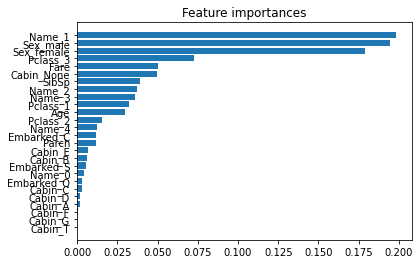

In [10]:
### feature importance visualization
import numpy as np
import matplotlib.pyplot as plt
importances = classifier.feature_importances_
indices = np.argsort(importances)
columns = np.array(dummy_df_all.columns)
plt.title("Feature importances")
plt.barh(columns[indices], importances[indices], align="center")

### Data Visualization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


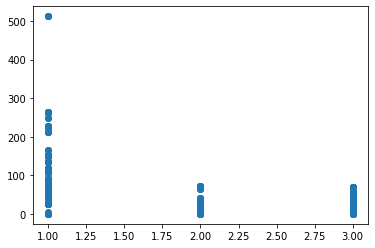

In [13]:
### Pclass v.s. Fare
import pandas as pd
train = pd.read_csv('train.csv')
target_cols = train[['Pclass', 'Fare']]
target_cols.dropna(inplace=True)
x_axis = target_cols['Pclass'].values
y_axis = target_cols['Fare'].values

import matplotlib.pyplot as plt
plt.scatter(x_axis, y_axis)

<BarContainer object of 9 artists>

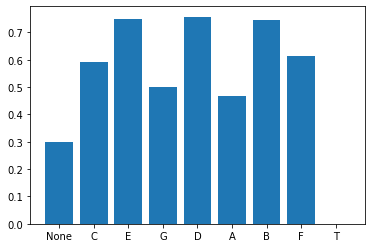

In [14]:
### Cabin v.s. Survival
def transform_text(text):
  if type(text) == str:
    return text.split()[0].strip('1234567890')
  else:
    return 'None'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
train = pd.read_csv('train.csv')
train['Cabin'] = train['Cabin'].apply(transform_text)
class_count_group = train.groupby(['Survived', 'Cabin'])
classes = train['Cabin'].unique()
class_size = [0 for i in range(classes.size)]
class_survive_size = [0 for i in range(classes.size)]
for group, df in class_count_group:
  idx = np.where(classes == group[1])[0][0]
  if group[0] == 1: # survival
    class_survive_size[idx] = len(df)
  class_size[idx] += len(df)
class_survival_rate = [class_survive_size[i]/class_size[i] for i in range(classes.size)]
plt.bar(classes, class_survival_rate)